**From the instructions**

Vision: Programming is more than writing code. The ultimate goal of the projects in this course
is that you learn to formulate a programming problem of your own choice, and find your own way
to solve it, and present the results. The bullets below are minimum requirements, but otherwise it is
very much up to you, what you will like to do with your project. I hope to see some creative ideas!

• Objectives: In your model analysis project, you should show that you can:
1. Apply model analysis methods (e.g. scipy.optimize, scipy.linalg, sympy)
2. Structure a code project
3. Document code
4. Present results in text form and in figures

• Content: In your model analysis project, you should at a minimum:
1. Describe an algorithm on how to solve a simple economic model (most likely taken from a textbook)
2. Solve (and perhaps simulate) a simple economic model
3. Visualize results across e.g. parametrizations
4. Analyze one or more extensions of the baseline model

• Structure: Your data analysis project should consist of:
1. A README.md with a short introduction to your project
2. A single self-contained notebook (.ipynb) presenting the analysis
3. (Optionally) Fully documented Python files (.py)


• Size: Quality before quantity.

• Hand-in: On GitHub by uploading it to the folder:
github.com/projects-2019-YOURGROUPNAME/modelproject/
• Deadline: 10th of May 23.59

• Supervision: The exercises class in the weeks starting 29th of April and 6th of May will
give you time to work on your model project and receive supervision from the lecturer and the
teaching assistants. Also, remember the online forum.

• Peer feedback: After handing in, you will be asked to give peer feedback on the projects of
two other groups.

• Exam: Your model analysis project will be a part of your exam portfolio. You are free to
incorporate the peer feedback and other comments before handing in the final version.

#### Imports

In [134]:
#Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
#import seaborn as sns

import sympy as sm
import scipy as sp
from scipy import linalg
from scipy import optimize, arange
from scipy import interpolate


from functions import price, cost, profit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction - Cournot Competition

## The general setup

$N\geq2$ firms compete in an industry with a homogenous good, where each firm maximises their own profits by choosing a quantity to produce (the production) taking the production from other firms as given.

The inverse aggregate market demand for the homogenous good is assumed to be downwards sloping and linear:
$$
P=\max\{a-bQ,0\}
$$
Where $P$ is the price for the homogenous good and $a,b>0$ are parameters that reflect the demand of consumers. $Q$ is the industry output, defined as the sum of all $N$ individual firms' production:
$$
Q=\sum_{i=1}^N q_i
$$

It can be helpful for notation purposes to define the sum of all other firms' production from the point of view of firm $i$ as:
$$
Q_{-i}=Q-q_i
$$

Firms are not necesarrily homogenous in their costs - rather, firms may have assymmetric marginal costs $c_i>0$ with no capacity constraints. Thus, each firms maximises profit by choosing production level:

$$
\max_{q_i}\pi_i=Pq_i-c_iq_i\Leftrightarrow \max_{q_i}\pi_i=(a-b(Q_{-i}+q_i)-c_iq_i
$$
s.t.
$$
q_i\geq 0
$$
$$
a,b,c_i> 0
$$

Where firms are $i=1,...,N$

This is a classic Industrial Organisation problem, where firms act strategically, taking the actions of other firms into account. 

Specifically, this means that in order to solve model, we must:
- Find the best response function for each individual firm (i.e. what quantity will the firm produce as a function of the other firms' production)
- Find the equilibrium, where all firms have no incentive to deviate - i.e. they are best-responding to each other.

## The simple case - $N=2$

In order to build up our general purpose function, we start off with the simple case, where $N=2$, which means that inverse demand is (using supscripts $i$ and $j$):
$$
P=\max\{a-b(q_i+q_j), 0\}
$$

And the individual firm's maxmisation problem:

$$
\max_{q_i}\pi_i=(a-b(q_i+q_j)-c_iq_i
$$
s.t.
$$
q_i\geq 0
$$
$$
a,b,c_i> 0
$$

### Defining functions

First, we define the relevant inverse demand (also called price) function, cost function and profit functions - these functions are symmetric across firms (only input needs to be changed).

The functions are included in the `functions.py` module.

First, we'll just show off the simple functions for some random parameters:

In [2]:
#Initializing some random values for the parameters
a = 100
b = 1
c1 = 1
c2 = 3
q1 = 35
q2 = 25

In [3]:
cost(q1, c1)

35

In [4]:
cost(q2, c2)

75

In [5]:
price(q1, q2, a, b)

40

In [6]:
profit(q1, q2, a, b, c1)

1365

In [7]:
profit(q1, q2, a, b, c2)

1295

#### Best reponse function

Our first problem is to find the best response function - to do this, we minimise the negative `profit` function (i.e. maximising the profit) by choosing a best response quantity produced for given levels of production from the other firm. 

To do this, we use the `optimize.fminbound` from `scipy`. We use this function as we want to bound the production of firms as we do wish to have unrealistic solutions with e.g. negative quantities produced.

In [8]:
from functions import best_response

We now have a given firms best response to any level of production from the other firm, given the firms' own costs - let's see isolated examples for firm 1:

In [106]:
#Some random parameter choices
a = 100
b = 1
c1 = 1
q2 = 25


print("Firm 1's best response to firm 2's production, " + str(q2) + ", is a production of " + str("{:.0f}".format(best_response(q2, c1, a, b))))

#Changing firm 2's production to see response from firm 1
q2 = 50

print("Firm 1's best response to firm 2's production, " + str(q2) + ", is a production of " + str("{:.0f}".format(best_response(q2, c1, a, b))))

Firm 1's best response to firm 2's production, 25, is a production of 37
Firm 1's best response to firm 2's production, 50, is a production of 24


We can plot the best response function, i.e. quantity produced as response to the other firms' production, for some given parameters:


In [107]:
from functions import best_reponse_plot

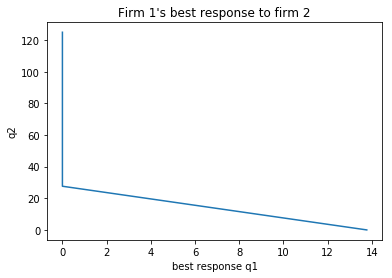

In [108]:
a = 125
b = 4.5
c1 = 1

best_reponse_plot(a, b, c1)

The plot shows that firm 1 will, for the given parameters, produce between 0 and 14 units depending on firm 2's production. If firm 2 produces around $30$ units, then firm 1 will not enter market - hence the kink in the best response function.

In order to check the validity of the numerical optimization, we will just contrast and compare to the analytical solution - first, we quickly define the analytical solution and plot functions:

In [12]:
def analytical_BR(q2, c1, a, b):
    BR=max((a-b*q2-c1)/(2*b), 0) #solution found by taking the FOC of the profit function
    return BR


In [13]:
def best_reponse_plot_Analytical(a, b, c1):
    range_q2 = arange(0, a, 0.01)
    range_q1 = [analytical_BR(q2, c1, a, b) for q2 in range_q2]
    
    plt.plot(range_q1, range_q2)
    plt.xlabel("best response q1")
    plt.ylabel('q2')
    plt.title("Firm 1's best response to firm 2 - analytical")

Numerical vs. analytical solution

Text(0.5, 1.0, 'Analytical')

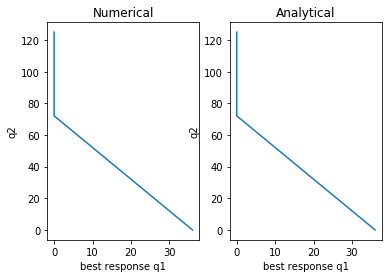

In [14]:
#Numerical vs. analytical solution
a = 125
b = 1.7
c1 = 2.5

#Numerical
plt.subplot(1, 2, 1)
best_reponse_plot(a, b, c1)
plt.title('Numerical')

#Analyltical
plt.subplot(1, 2, 2)
best_reponse_plot_Analytical(a, b, c1)
plt.title("Analytical")

We can see that our numerical solution mirrors the analytical solution, so we are headed in the right direction.

### Equilibrium

In order to find the equilibrium, we need to find a solution, where both firms are best responding to each other - i.e. a Nash equilibrium, where there are no incentives to deviate.

We do this by defining a help function, which find a fixed point - i.e. a point where $q - \text{best_response}(\cdot)=0$, which means that the current production is equal to the best response. This help function can be used in `scipy`'s `fsolve` module from which we can find our equilibrium production for both firms in equilibrium.


In [15]:
from functions import help_br, production_eq

The equilibrium production function, `production_eq`, takes in as arguments the following:
- a list or array of costs for each firm
- An initial guess for `fsolve` module solutions - usually set to no production for both firms i.e. [0,0]
- Values for the demand parameters, $a$ and $b$

It then returns an array with the production for each firm.

In [16]:
#Some parameters
initial_guess = [0,0] #to solve the equilibrium
c = [10,4] #costs for each firm
a = 217
b = 2.7


In [17]:
#Production for each firm corresponding to the costs defined by c
production_eq(c, initial_guess, a, b)

array([24.81481481, 27.03703704])

If we utilize all of our functions together in the function `summary` combined with some printing of strings, we can print out the results for a given game:

In [18]:
from functions import summary

In [19]:
#Some parameters
initial_guess = [0,0] #to solve the equilibrium
c = [4,4] #costs for each firm - symmetric
a = 100
b = 1

#Prints out summary of the Cournot game
summary(c, a, b, initial_guess)


 Industry output is 64 with firm 1 producing 32 units and firm 2 producing 32 units.
 The equilibrium price per unit becomes 36
 Firm 1's profit will be 1024 while firm 2's profit will be 1024


In [21]:
initial_guess = [0,0] #to solve the equilibrium
c = [4,15] #costs for each firm - firm 1 is more cost efficient
a = 100
b = 1

#Prints out summary of the Cournot game
summary(c, a, b, initial_guess)


 Industry output is 60 with firm 1 producing 36 units and firm 2 producing 25 units.
 The equilibrium price per unit becomes 40
 Firm 1's profit will be 1272 while firm 2's profit will be 880


In [22]:
initial_guess = [0,0] #to solve the equilibrium
c = [4,15] #costs for each firm - firm 1 is more cost efficient
a = 100
b = 2.5

#Prints out summary of the Cournot game
summary(c, a, b, initial_guess)


 Industry output is 24 with firm 1 producing 14 units and firm 2 producing 10 units.
 The equilibrium price per unit becomes 40
 Firm 1's profit will be 509 while firm 2's profit will be 352


## The general case for $N\geq 2$

We did not succeed in solving the general version of the model numerically. 

Thus, we will proceed by showing the properties of the model by utilizing the analytical solution to simulate the general model.

Importing the analytical solution generators:

In [99]:
from functions import price_eq, qi_eq, Q_eq, profit_eq

See the `functions` module for documentation.

In [150]:
a = 500
b = 7.5
n = random.randint(2, 50)

c = []
for i in range(0, n+1, 1):
    c_i = random.randint(1, 10)
    c.append(c_i)

In [155]:
def summary_general(a, b, N, c_low, c_high): # N is the max number of firms
    n = random.randint(1, N) #Number of firms - can be from monopoly to perfect competition depending on the draw (and N)
    
    #Assymmetric costs for each firm:
    c = []
    for i in range(0, n+1, 1):
        c_i = random.randint(c_low, c_high)
        c.append(c_i)
    
    price = price_eq(a, n, c) #equilibrium price
    
    output 
    return output

In [156]:
a = 500
b = 7.5
N = 50
c_low = 1
c_high = 10

summary_general(a, b, N, c_low, c_high)

119.25

In [ ]:
# defining summary function
def summary_general(c, a, b):
    
    for i in range(0, n+1, 1):
        qi_eq(a, b, n, c, i)
        
    output = 

In [ ]:
def summary(c, a, b, initial_guess):
    q1,q2 = production_eq(c, initial_guess, a, b) #Equilibrium productions   
     
    output = print('\n Industry output is ' + str("{:.0f}".format(q1+q2)) + ' with firm 1 producing ' + str("{:.0f}".format(q1)) + ' units and firm 2 producing ' +
                   str("{:.0f}".format(q2)) + ' units.' + 
                   '\n The equilibrium price per unit becomes ' + str("{:.0f}".format(price(q1, q2, a, b))) +
                  "\n Firm 1's profit will be " + str("{:.0f}".format(profit(q1, q2, a, b, c[0]))) + " while firm 2's profit will be " + str("{:.0f}".format(profit(q1, q2, a, b, c[1]))))
    return output

### Nested perfect competition

We will try and show how perfect competition conditions i.e. zero profits when the number of firms goes up by simulation.

First, we will choose a range of $N$, i.e. the number of firms to simulate over. Then we will generate uniformly distributed costs for each of the firms.

Lastly, we will plot how a given reacts and $N$ increases.

Parameter choices and simulation:

In [146]:
n = range(1, 101, 1) # 101 firms

c = []
for i in range(0, max(n), 1): #Uniformly distributed costs
    #c_i = 2
    #c.append(c_i)
    c_i = random.randint(1, 20)
    c.append(c_i)

a = 1000
b = 10

Profits for firm 7 as $N$ increases:

In [147]:
profit_n = [] # Firm
for x in n:
    profit_n.append(profit_eq(a, b, x, c, 7))    

Plot of firm 7's profits:

Text(0.5, 1.0, "Firm 1's best response to firm 2")

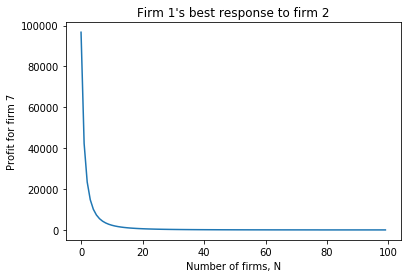

In [148]:
plt.plot(profit_n)
plt.xlabel("Number of firms, N")
plt.ylabel('Profit for firm 7')
plt.title("Firm 1's best response to firm 2")

As expected, the more firms that compete, the closer we are to the perfect competition scenario.

In [32]:
a = 500
b = 7.5
n = random.randint(2, 50)

c = []
for i in range(0, n+1, 1):
    c_i = random.randint(1, 10)
    c.append(c_i)



15


In [27]:
profit_eq(a, b, n, c, i)

12356.585034013604